In [7]:
import webbpsf
import matplotlib.pylab as plt
import poppy
import numpy as np
import matplotlib.pylab as plt
from astropy.io import fits
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import LinearStretch, LogStretch, AsinhStretch
import os
from astropy.modeling import models, fitting
import astropy
import datetime

In [2]:
!pwd

/Users/melendez/WFSC_Flight


# JWST Using Wavefronts Measured On Orbit
### WebbPSF now includes code for using the results of in-flight wavefront sensing measurements, by retrieving Optical Path Difference (OPD) 

https://webbpsf.readthedocs.io/en/latest/jwst_measured_opds.html

## Index
* [Finding the measured wavefront near a given date](#opd)
* [Trending Wavefront Changes over Time](#trending)
* [Wavefront time series and histogram plots](#time)
* [Load a Single OPD](#single)
* [PSF properties and differences ](#psfdiff)


For other WebbPSF examples:
https://webbpsf.readthedocs.io/en/latest/more_examples.html

In [ ]:
#Let's get the latest webbpsf-data 
print("Downloading data...")
!wget  https://stsci.box.com/shared/static/t90gqazqs82d8nh25249oq1obbjfstq8.gz -O ~/webbpsfdata.tar.gz
print("Extracting data...")
!tar zxf ~/webbpsfdata.tar.gz -C ~/
!rm ~/webbpsfdata.tar.gz
print("Finished.")

In [11]:
#set your WebbPSF data folder
# webbpsf-data-1.1.1.tar.gz 
# https://stsci.box.com/shared/static/t90gqazqs82d8nh25249oq1obbjfstq8.gz
webbpsf.__path__
%env WEBBPSF_PATH=/home/jovyan/webbpsf-data/
os.environ["WEBBPSF_PATH"]

# Optional: set your output folder when working with OPDs. Default: $WEBBPSF_PATH
output_path = "/home/jovyan/"

env: WEBBPSF_PATH=/Users/melendez/Documents/webbpsf-data


<a id='opd'></a>
### Finding the measured wavefront near a given date

In [13]:
nrc = webbpsf.NIRCam()
nrc.filter='F200W'

nrc.detector = 'NRCB2'
nrc.detector_position = (1024,1024)


MAST OPD query around UTC: 2022-07-01T00:00:00.000
                        MJD: 59761.0

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022063002-NRCA3_FP1-2.fits
	Date (MJD):	 59759.6628
	Delta time:	 -1.3372 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022070403-NRCA3_FP1-0.fits
	Date (MJD):	 59761.5484
	Delta time:	 0.5484 days
User requested choosing OPD time closest in time to 2022-07-01T00:00:00.000, which is R2022070403-NRCA3_FP1-0.fits, delta time 0.548 days
Importing and format-converting OPD from /ifs/jwst/tel/flight/WebbPSF-OPD/R2022070403-NRCA3_FP1-0.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point


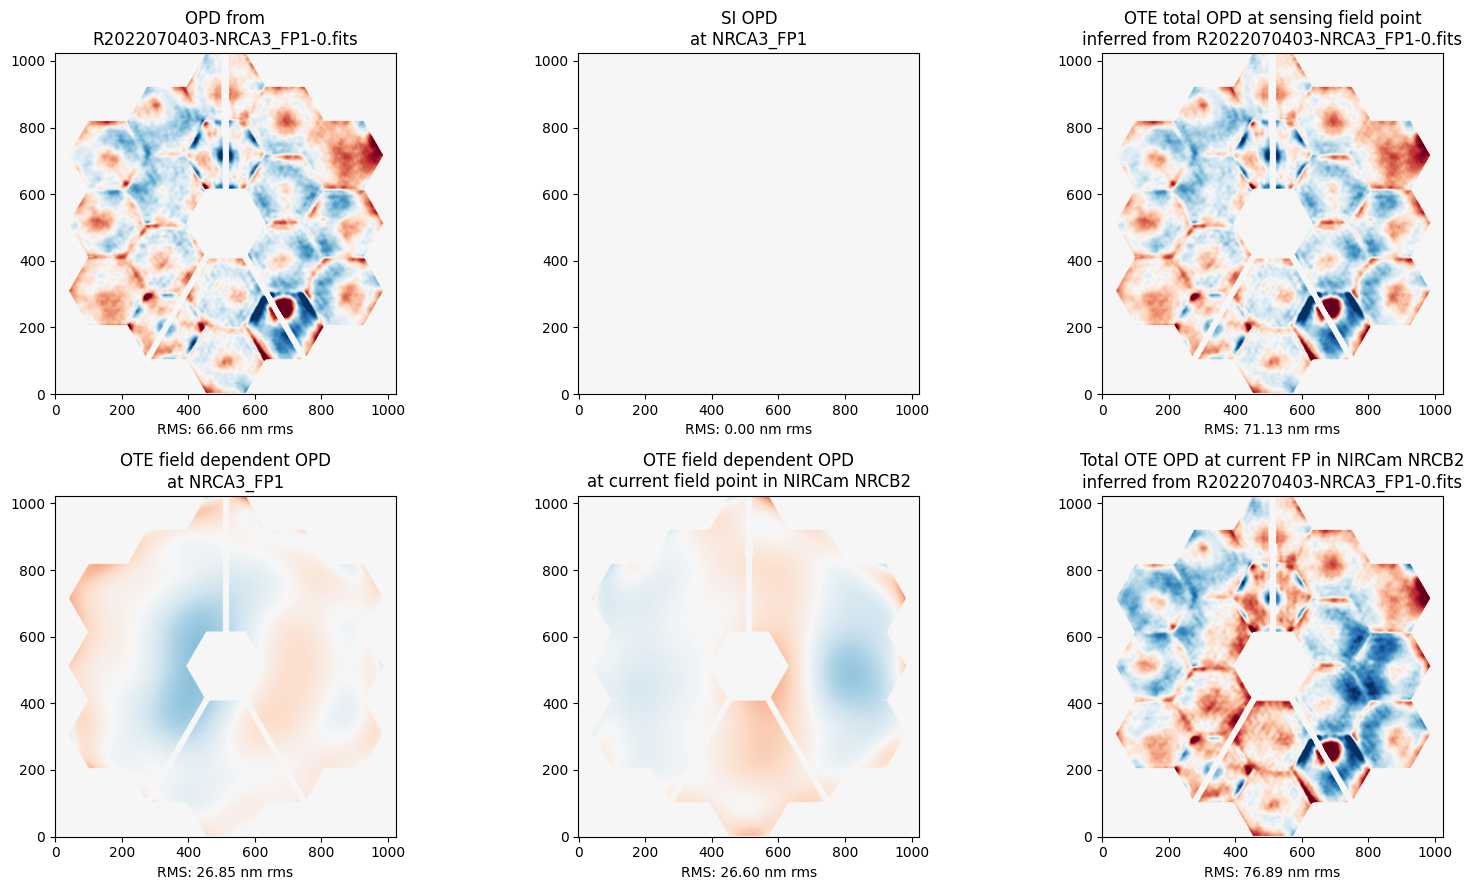

In [14]:
nrc.load_wss_opd_by_date('2022-07-01T00:00:00',plot=True, output_path = output_path)

- Upper Left: This is the measured OPD as sensed in NIRCam at “field point 1” which is in the upper left corner of NRCA3, relatively close to the center of the NIRCam module. This observatory total OPD measurement includes both the telescope and NIRCam contributions to the WFE.

- Upper Middle: This is the wavefront map for the NIRCam portion of the WFE at that field point. This is known from ground calibration test data, not measured in flight.

- Upper Right: That NIRCam WFE contribution is subtracted from the total observatory WFE to yield this estimate of the OTE-only portion of the WFE.

- Lower Left and Middle: These are models for the field dependence of the OTE OPD between the sensing field point in NRCA3 and the requested field ooint, in this case in NRCB2. This field dependence arises mostly from the figure of the tertiary mirror. These are used to transform the estimated OTE OPD from one field position to another.

- Lower Right: This is the resulting estimate for the OTE OPD at the requested field point, in this case in NRCB2.

Filename: /ifs/jwst/tel/flight/WebbPSF-OPD/R2022070403-NRCA3_FP1-0.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      23   ()      
  1  RESULT_PHASE    1 ImageHDU       184   (256, 256)   float32   
  2  RESULT_PSF    1 ImageHDU        11   (545, 545)   float32   
  3  EXPECTED      1 ImageHDU        13   (256, 256)   float32   
  4  PUPIL_MASK    1 ImageHDU        11   (256, 256)   int16   
  5  RAW_PSF       1 ImageHDU        14   (256, 256)   float32   
  6  CALC_PSF      1 ImageHDU        12   (546, 546)   float32   
  7  CALC_AMP      1 ImageHDU        12   (256, 256)   float32   
  8  HO_PHASE      1 ImageHDU        12   (256, 256)   float32   
  9  LO_PHASE      1 ImageHDU        12   (256, 256)   float32   
 10  RAW_PSF       1 ImageHDU        14   (256, 256)   float32   
 11  CALC_PSF      1 ImageHDU        12   (546, 546)   float32   
 12  CALC_AMP      1 ImageHDU        12   (256, 256)   float32   
 13  HO_PHASE      1 Im

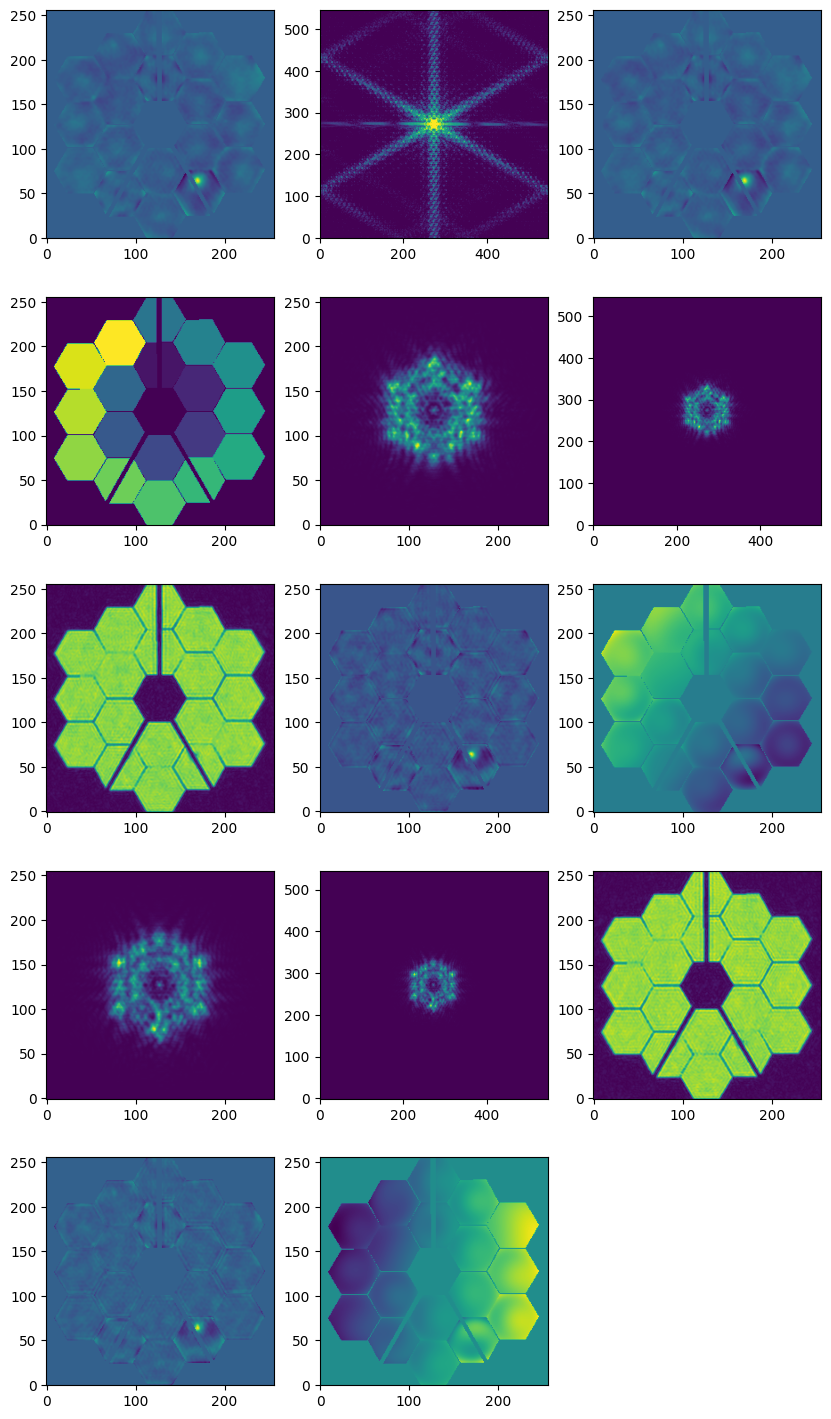

In [6]:
#What's inside an OPD?

opd_fn = 'R2022070403-NRCA3_FP1-0.fits'
opd = fits.open(os.path.join(output_path,opd_fn))

opd.info()



norm = ImageNormalize(stretch=LogStretch(), vmin = 1e-10 , vmax = 1e-6)
plt.figure(figsize = [10,18])
for i in range(1,len(opd)):
    plt.subplot(5,3,i)
    if i == 2:
        plt.imshow(opd[i].data, norm = norm, origin = 'lower')
    else:
        plt.imshow(opd[i].data, origin = 'lower')




## OPD File description

- RESULT_PHASE Image Extension. 
The FITS file contains a ‘RESULT’ image extension, which is the average of the optical path difference results from all images analyzed together in the phase retrieval 

- RESULT_PSF Image Extension 
The FITS file contains a ‘RESULT_PSF’ image extension, which is the PSF computed from the resultant phase by the WAS 

- EXPECTED Image Extension
The FITS file contains an ‘EXPECTED’ image extension, which is the expected optical path difference if the WAS-recommended correction is applied 

- PUPIL_MASK Image Extension 
The FITS file contains a ‘PUPIL_MASK’ image extension, which is the pupil mask used to compute the PSF from the resultant phase 


### The FITS file contains five image extensions for each analyzed input image. In the case of the sensing program, there are 2 images +/-8WL


- RAW_PSF Image Extensions 
For each input image, the Raw PSF extension will contain the raw extracted subimage taken from the calibrated science data 

- CALC_PSF Image Extensions 
For each input image, the Calculated PSF extension will contain an image which represents the estimated PSF as calculated by the phase retrieval process 

- CALC_AMP Image Extension 
For each input image, the Calculated Amplitude extension will contain an image which represents the estimated pupil amplitude as calculated by the phase retrieval process 

- HO_PHASE Image Extension 
For each input image, the High-Order Phase extension will contain an image which represents the retrieved phase information minus the Low-Order (controllable) phase as calculated by the phase retrieval process. 

- LO_PHASE Image Extension 
For each input image, the Low-Order Phase extension will contain an image which represents the retrieved controllable phase information as calculated by the phase retrieval process 



In [7]:
#Let's simulate Webb's PSF from the OPD above
# The PSF below is calculated using the actual 
# as-measured-at-L2 state of the telescope WFE near 
# the requested date, in this case 2022 July 1.
psf = nrc.calc_psf(fov_pixels=101)


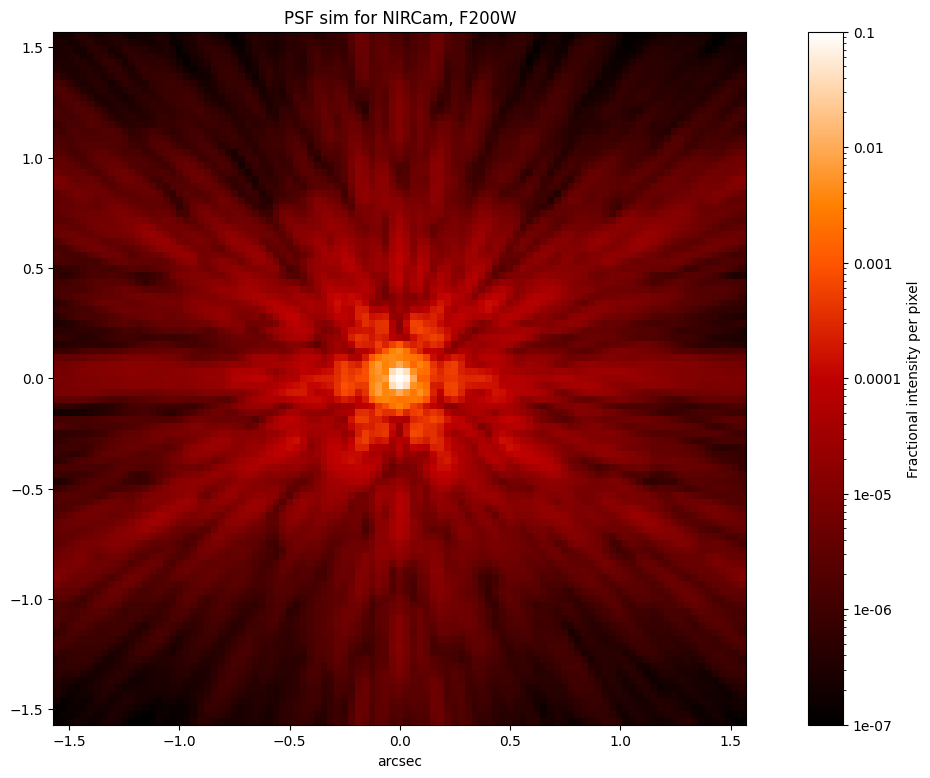

In [8]:
plt.figure(figsize=(16,9))
webbpsf.display_psf(psf, ext=1)

<a id='trending'></a>
### Trending Wavefront Changes over Time


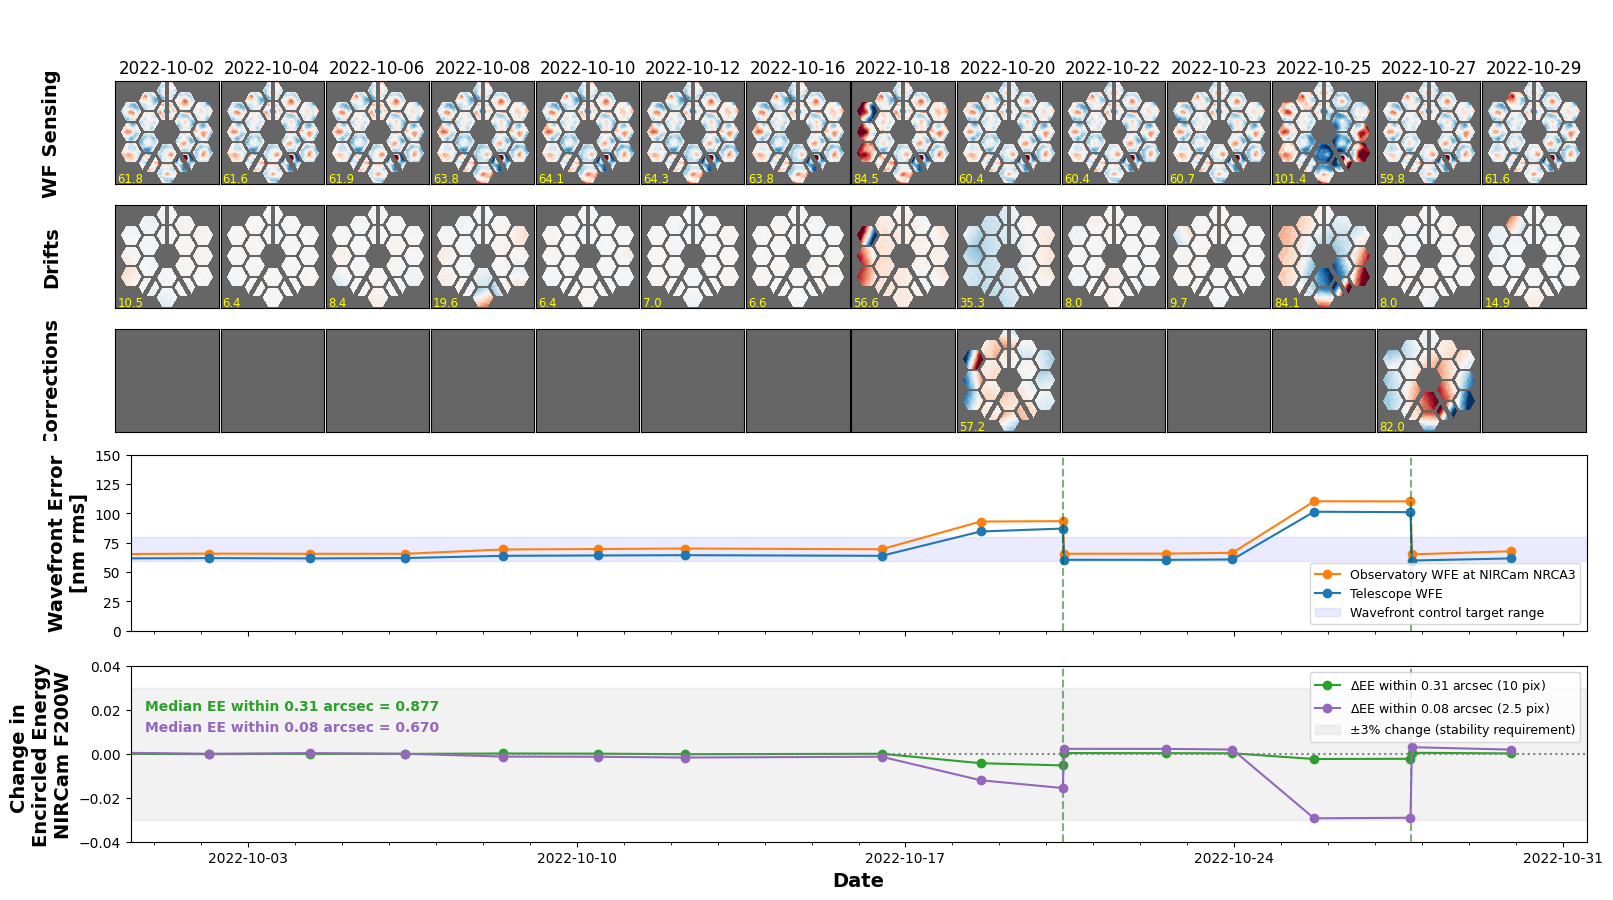

In [32]:
trend_table = webbpsf.trending.monthly_trending_plot(2022, 10, verbose=False)


In [33]:
trend_table

<QTable length=17>
          Date                    Filename               WFS Type      RMS WFE (OTE+SI)  RMS WFE (OTE only)    EE(2.5 pix)         EE(10pix)     
                                                                              nm                 nm                                              
         str23                     str29                  str16            float64            float64            float64            float64      
----------------------- ---------------------------- ---------------- ------------------ ------------------ ------------------ ------------------
2022-09-27T22:01:26.200 O2022092801-NRCA3_FP1-1.fits          Sensing   64.7259251354915  61.25122934992116 0.6714148681735586 0.8773118543071078
2022-10-02T04:12:36.900 O2022100201-NRCA3_FP1-1.fits          Sensing  65.68874394288746  61.83816373813852 0.6703370968725068  0.877031625660122
2022-10-04T07:46:44.700 O2022100401-NRCA3_FP1-1.fits          Sensing  65.50802012623127 61.569281559760874 0.6706375881379684  0.877149035925566
2022-10-06T08:29:18.800 R2022100803-NRCA3_FP1-1.fits          Sensing  65.54037291212907 61.874568456002315 0.6703428219227119 0.8771304946354058
2022-10-08T10:22:06.300 R2022100805-NRCA3_FP1-1.fits          Sensing  69.21078142231433  63.79921246515536 0.6690576777236501 0.8773172835485827
2022-10-10T10:48:41.800 R2022101104-NRCA3_FP1-1.fits          Sensing  69.58472799780755  64.10061591700506 0.6689689392369498 0.8772501346121296
2022-10-12T07:12:39.800 R2022101302-NRCA3_FP1-1.fits          Sensing  70.02409380339236  64.33458003235047 0.6686222503530936 0.8769845780000878
2022-10-16T11:46:51.000 R2022101702-NRCA3_FP1-1.fits          Sensing   69.3931230502431 63.796001526836655 0.6689910845088193 0.8771907369194506
2022-10-18T14:22:14.300 R2022101904-NRCA3_FP1-1.fits          Sensing    93.023136714196  84.54325739078128  0.658296253141772 0.8729094817753155
2022-10-20T08:23:30.100 R2022102003-NRCA3_FP1-1.fits          Sensing  93.36514334329108  87.03553192959068 0.6547421557941648 0.8718860838248075
2022-10-20T09:03:35.100 R2022102005-NRCA3_FP1-1.fits Post Mirror Move  65.54559970823838   60.4091957555641 0.6725762538016018 0.8775113685821947
2022-10-22T12:52:33.600 O2022102201-NRCA3_FP1-1.fits          Sensing  65.67822155471752   60.3693635724684 0.6725625358908554 0.8774535619160313
2022-10-23T23:04:35.000 O2022102401-NRCA3_FP1-1.fits          Sensing  66.33534723916979 60.680041650724036 0.6722638007241045 0.8774063133189998
2022-10-25T16:47:30.900 R2022102607-NRCA3_FP1-0.fits          Sensing 110.25931909728038 101.38353020273972 0.6409860703721706 0.8748066099960717
2022-10-27T18:02:50.200 R2022102703-NRCA3_FP1-1.fits          Sensing 110.22170015282177 101.02319381985436 0.6412307275007245 0.8749010198314697
2022-10-27T18:47:45.200 R2022102704-NRCA3_FP1-1.fits Post Mirror Move  65.01217052412368  59.77107332164225 0.6733342888810616 0.8776271434782529
2022-10-29T21:17:41.100 R2022102904-NRCA3_FP1-1.fits          Sensing   67.6680881651766  61.57091998492044 0.6722318955924778  0.877353457106512

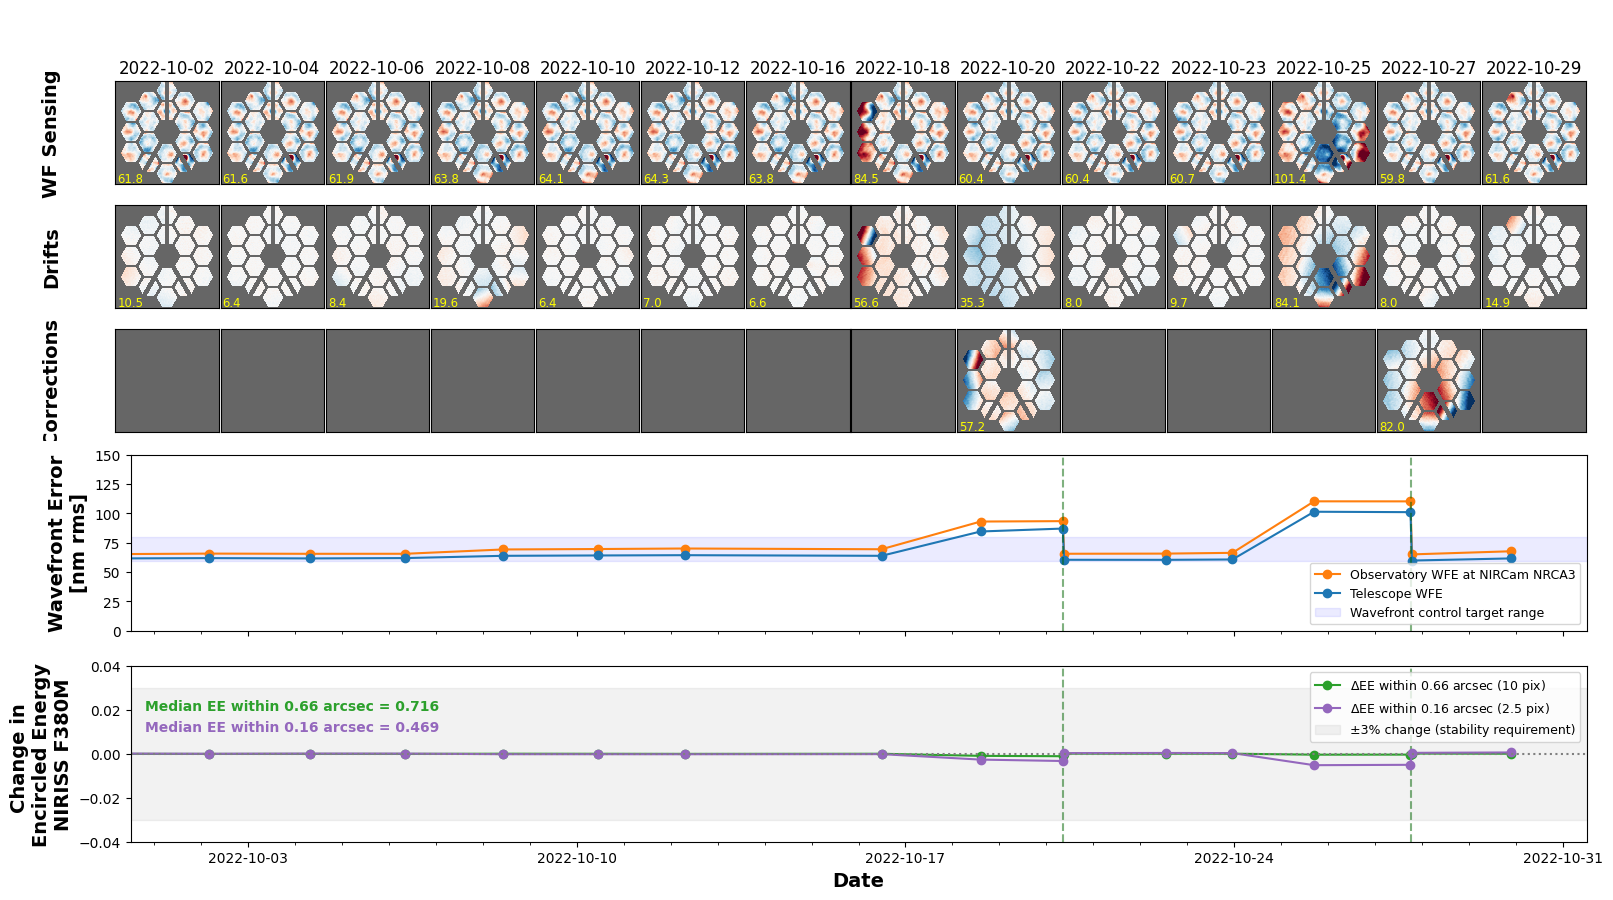

In [34]:
webbpsf.trending.monthly_trending_plot(2022, 10, verbose=False, instrument='NIRISS', filter='F380M');


<a id='time'></a>
### Wavefront time series and histogram plots


In [35]:
#We can retrieve a table of all available OPDs and plot the measurements over time:
opdtable = webbpsf.mast_wss.retrieve_mast_opd_table()
opdtable = webbpsf.mast_wss.deduplicate_opd_table(opdtable)
webbpsf.mast_wss.download_all_opds(opdtable)

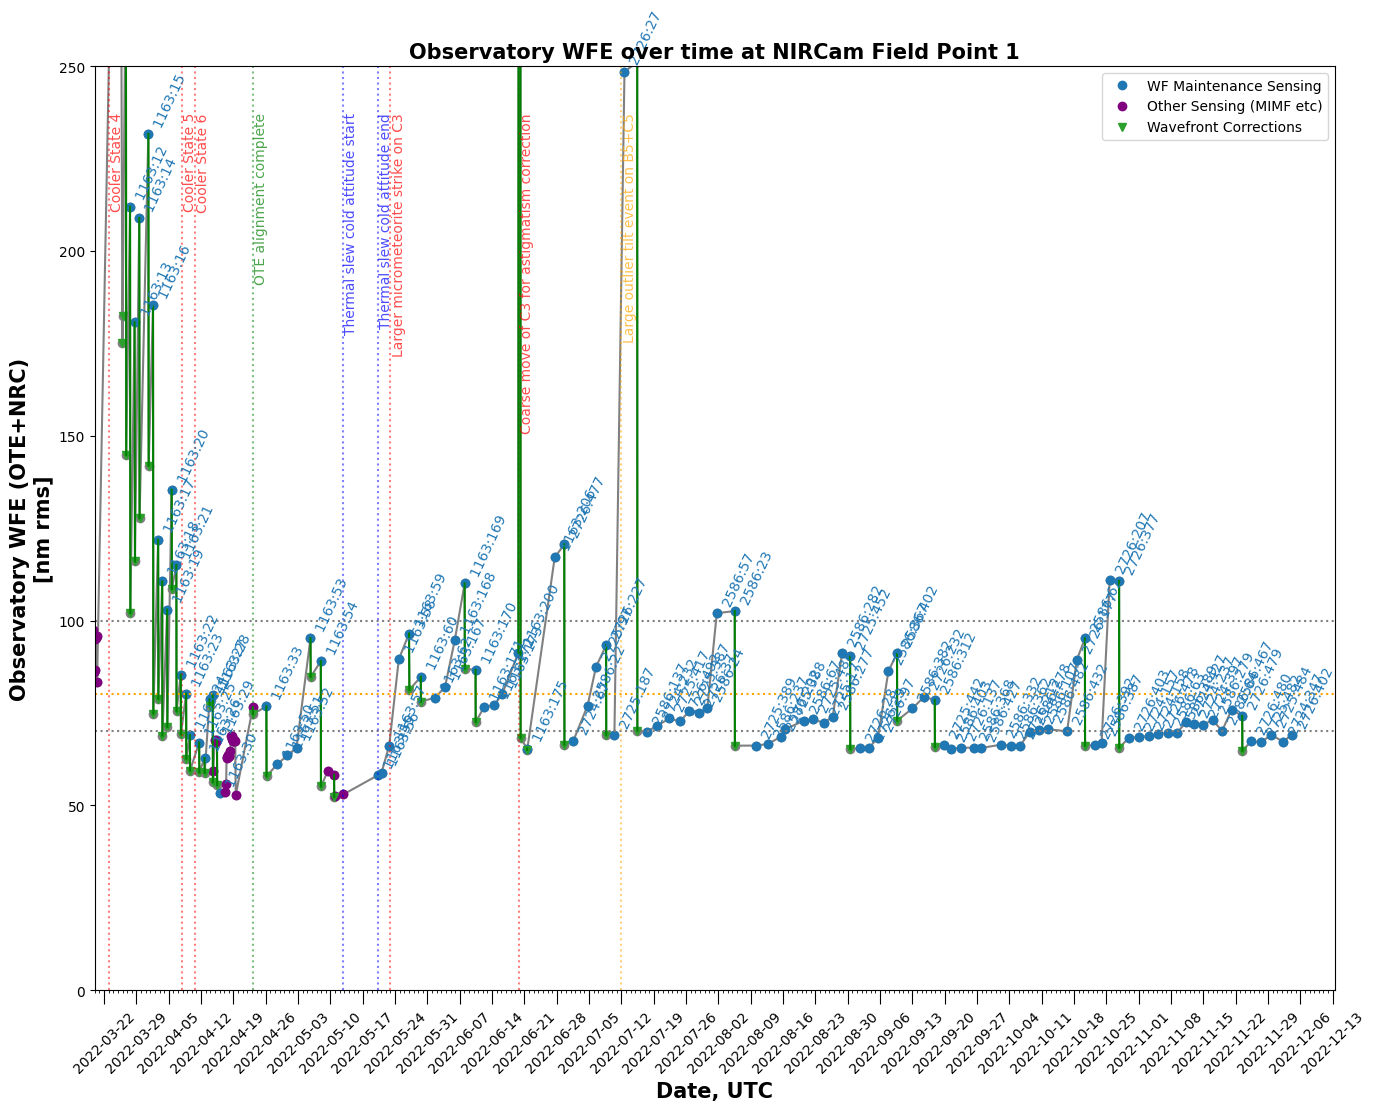

In [36]:
webbpsf.trending.wavefront_time_series_plot(opdtable)


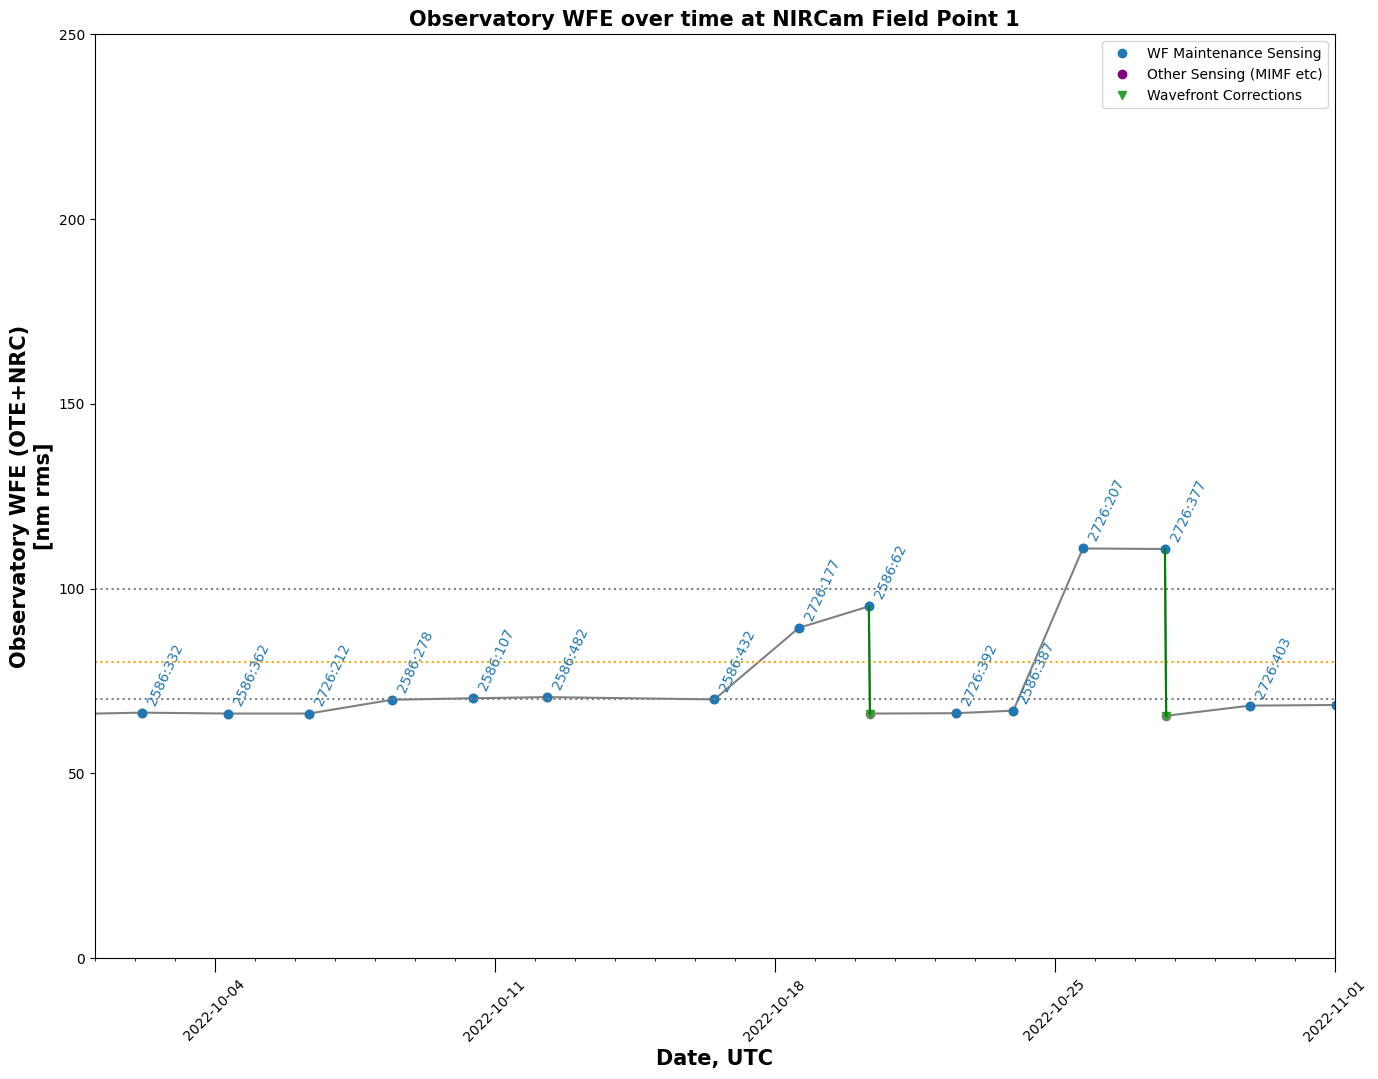

In [37]:
# Select a time range, depending on your observations
start_date =  datetime.datetime.fromisoformat('2022-10-01')
end_date =  datetime.datetime.fromisoformat('2022-11-01')
webbpsf.trending.wavefront_time_series_plot(opdtable, 
                                            start_date = start_date, end_date = end_date
                                           ,label_visits=True, label_events=True)

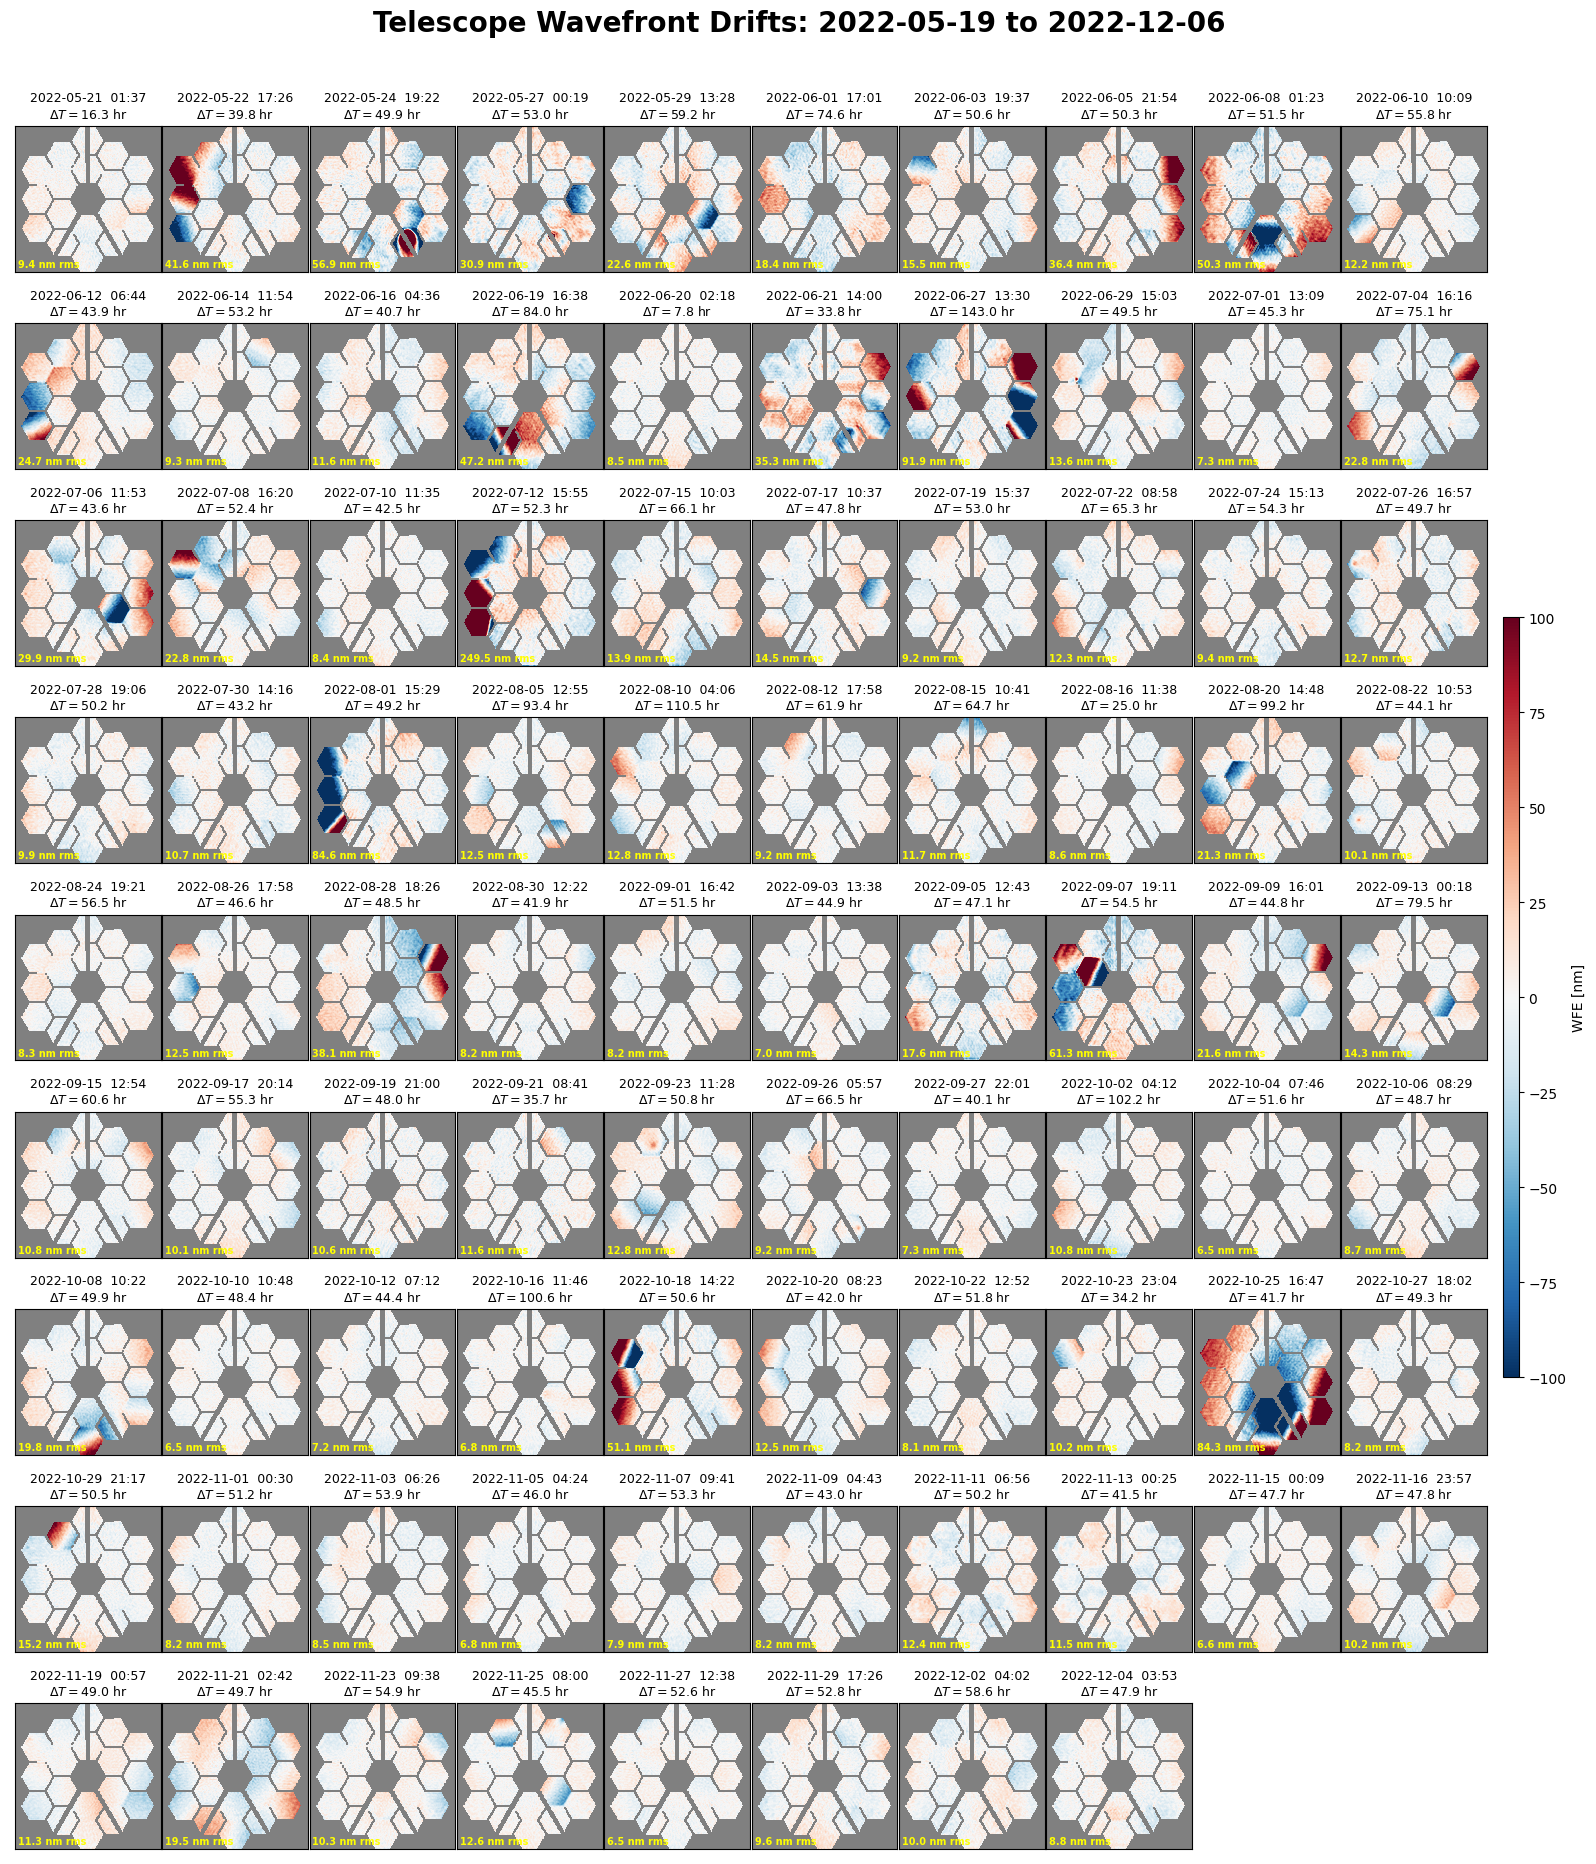

In [16]:
#We can also plot all measured wavefront drifts over specified time periods
start_time =  astropy.time.Time('2022-05-19T00:00:00')
end_time = astropy.time.Time.now()

webbpsf.trending.wavefront_drift_plots(opdtable, start_time=start_time, end_time=end_time, n_per_row=10)


In [17]:
opdtable

<Table length=210>
          date             date_obs_mjd      visitId    activity  apername   corr_id              fileName                               dataURI                     wfs_measurement_type is_post_correction is_pre_correction
         str23               float64          str12       str5      str9      str11                str29                                  str47                             str10                bool               bool      
----------------------- ------------------ ------------ -------- --------- ----------- ----------------------------- ----------------------------------------------- -------------------- ------------------ -----------------
2022-03-11T19:37:04.200  59649.81740972222 V01160001001    02109 NRCA3_FP1 R2022031401  R2022031401-NRCA3_FP1-0.fits  mast:JWST/product/R2022031401-NRCA3_FP1-0.fits                 post               True             False
2022-03-12T13:56:12.900  59650.58070486111 V01162001001    02101 NRCA3_FP1 O2022031301  O2022031301-NRCA3_FP1-1.fits  mast:JWST/product/O2022031301-NRCA3_FP1-1.fits                  pre              False             False
2022-03-12T19:42:19.800      59650.8210625 V01162006001    02101 NRCA3_FP1 R2022031401  R2022031401-NRCA3_FP1-6.fits  mast:JWST/product/R2022031401-NRCA3_FP1-6.fits                  pre              False             False
2022-03-13T02:02:19.300 59651.084945601855 V01162012001    02101 NRCA3_FP1 R2022031401 R2022031401-NRCA3_FP1-12.fits mast:JWST/product/R2022031401-NRCA3_FP1-12.fits                  pre              False             False
2022-03-14T15:44:07.500  59652.65564236111 V01163006001    02107 NRCA3_FP1 R2022031405  R2022031405-NRCA3_FP1-1.fits  mast:JWST/product/R2022031405-NRCA3_FP1-1.fits                 post               True             False
2022-03-17T06:50:00.300 59655.284725694444 V01163001001    02101 NRCA3_FP1 R2022032002  R2022032002-NRCA3_FP1-0.fits  mast:JWST/product/R2022032002-NRCA3_FP1-0.fits                  pre              False             False
2022-03-17T15:50:41.300  59655.66020023148 V01163003001    02101 NRCA3_FP1 R2022031703  R2022031703-NRCA3_FP1-1.fits  mast:JWST/product/R2022031703-NRCA3_FP1-1.fits                  pre              False             False
2022-03-17T22:54:02.800 59655.954199074076 V01163004001    02107 NRCA3_FP1 R2022031801  R2022031801-NRCA3_FP1-1.fits  mast:JWST/product/R2022031801-NRCA3_FP1-1.fits                 post               True             False
2022-03-18T05:18:33.700  59656.22122337963 V01163005001    02107 NRCA3_FP1 R2022032004  R2022032004-NRCA3_FP1-1.fits  mast:JWST/product/R2022032004-NRCA3_FP1-1.fits                 post               True             False
2022-03-18T16:43:01.500  59656.69654513889 V01166004001    02101 NRCA3_FP1 R2022032102  R2022032102-NRCA3_FP1-1.fits  mast:JWST/product/R2022032102-NRCA3_FP1-1.fits                  pre              False             False
2022-03-18T19:00:45.900 59656.792197916664 V01166009001    02101 NRCA3_FP1 R2022031902  R2022031902-NRCA3_FP1-2.fits  mast:JWST/product/R2022031902-NRCA3_FP1-2.fits                  pre              False             False
2022-03-18T21:33:50.500 59656.898501157404 V01166015001    02101 NRCA3_FP1 R2022031902  R2022031902-NRCA3_FP1-3.fits  mast:JWST/product/R2022031902-NRCA3_FP1-3.fits                  pre              False             False
2022-03-19T00:08:48.800  59657.00612037037 V01166021001    02101 NRCA3_FP1 R2022031902  R2022031902-NRCA3_FP1-4.fits  mast:JWST/product/R2022031902-NRCA3_FP1-4.fits                  pre              False             False
2022-03-19T02:43:03.700  59657.11323726852 V01166027001    02101 NRCA3_FP1 R2022031902  R2022031902-NRCA3_FP1-5.fits  mast:JWST/product/R2022031902-NRCA3_FP1-5.fits                  pre              False             False
2022-03-19T06:04:12.100  59657.25291782407 V01166033001    02101 NRCA3_FP1 R2022031902  R2022031902-NRCA3_FP1-6.fits  mast:JWST/product/R2022031902-NRCA3_FP1-6.fits                  pre     

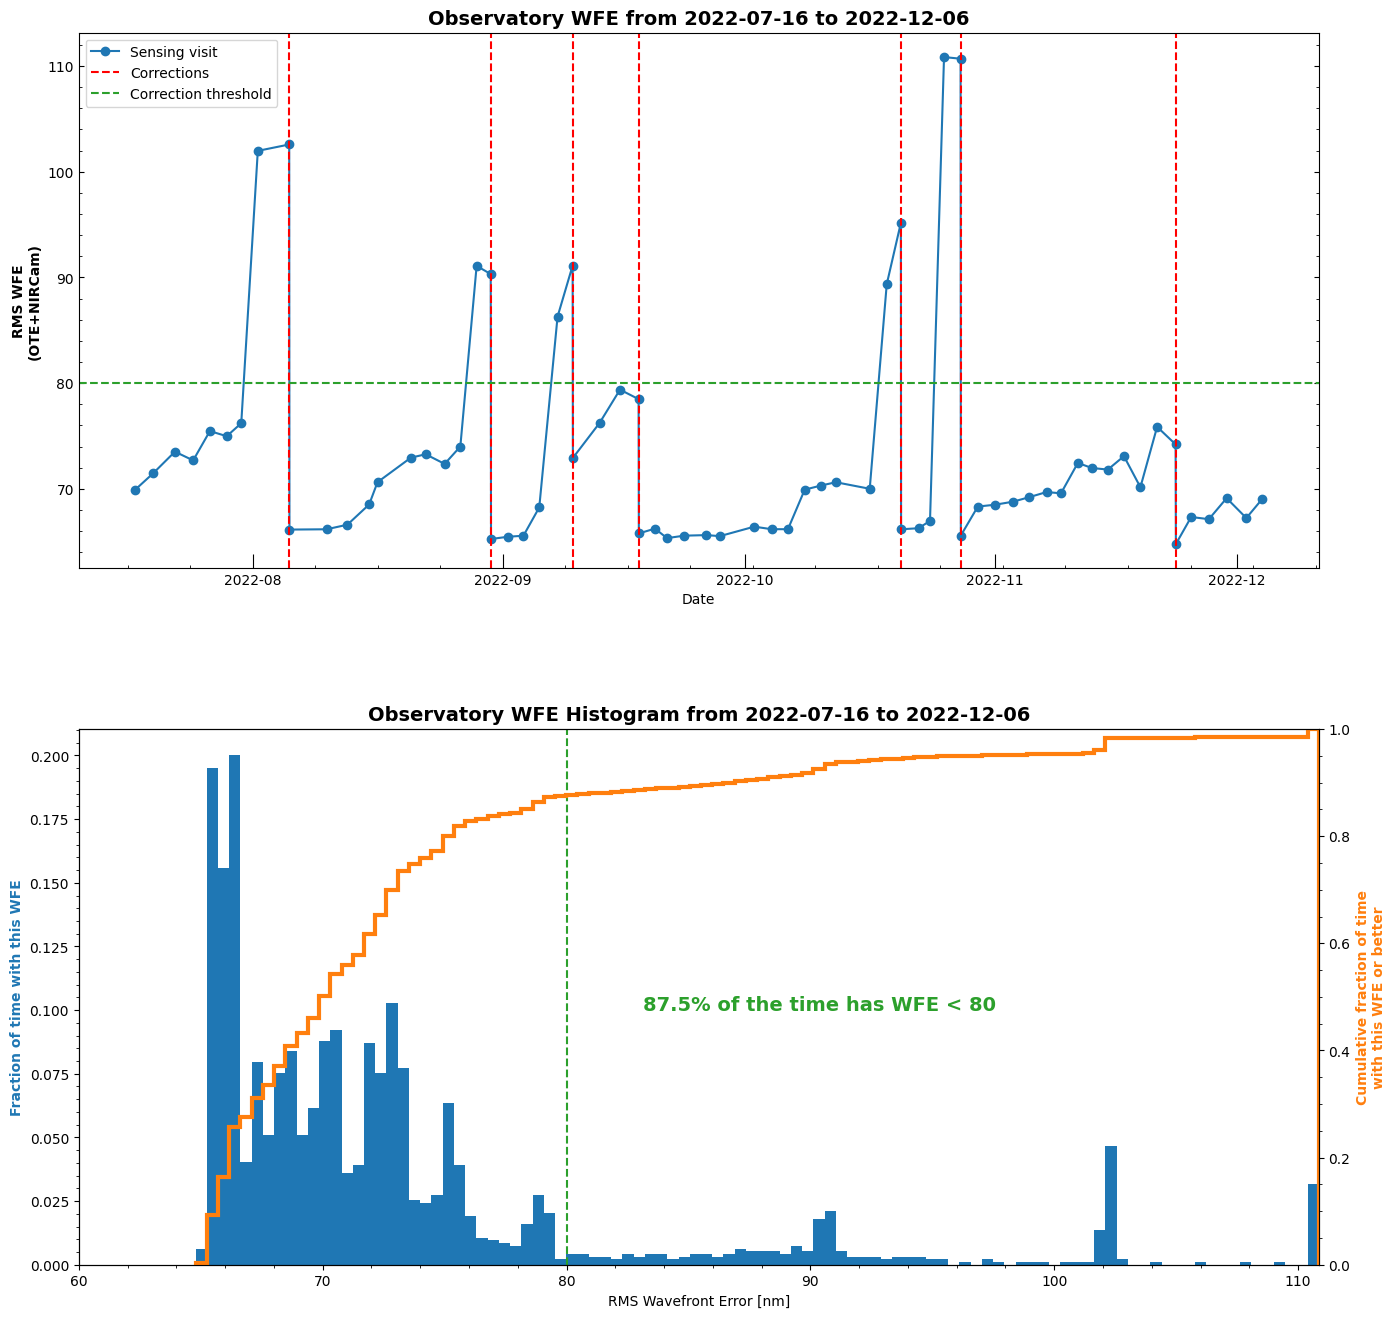

In [38]:
# we can plot histograms of wavefront error levels over time
webbpsf.trending.wfe_histogram_plot(opdtable,  thresh=80 )

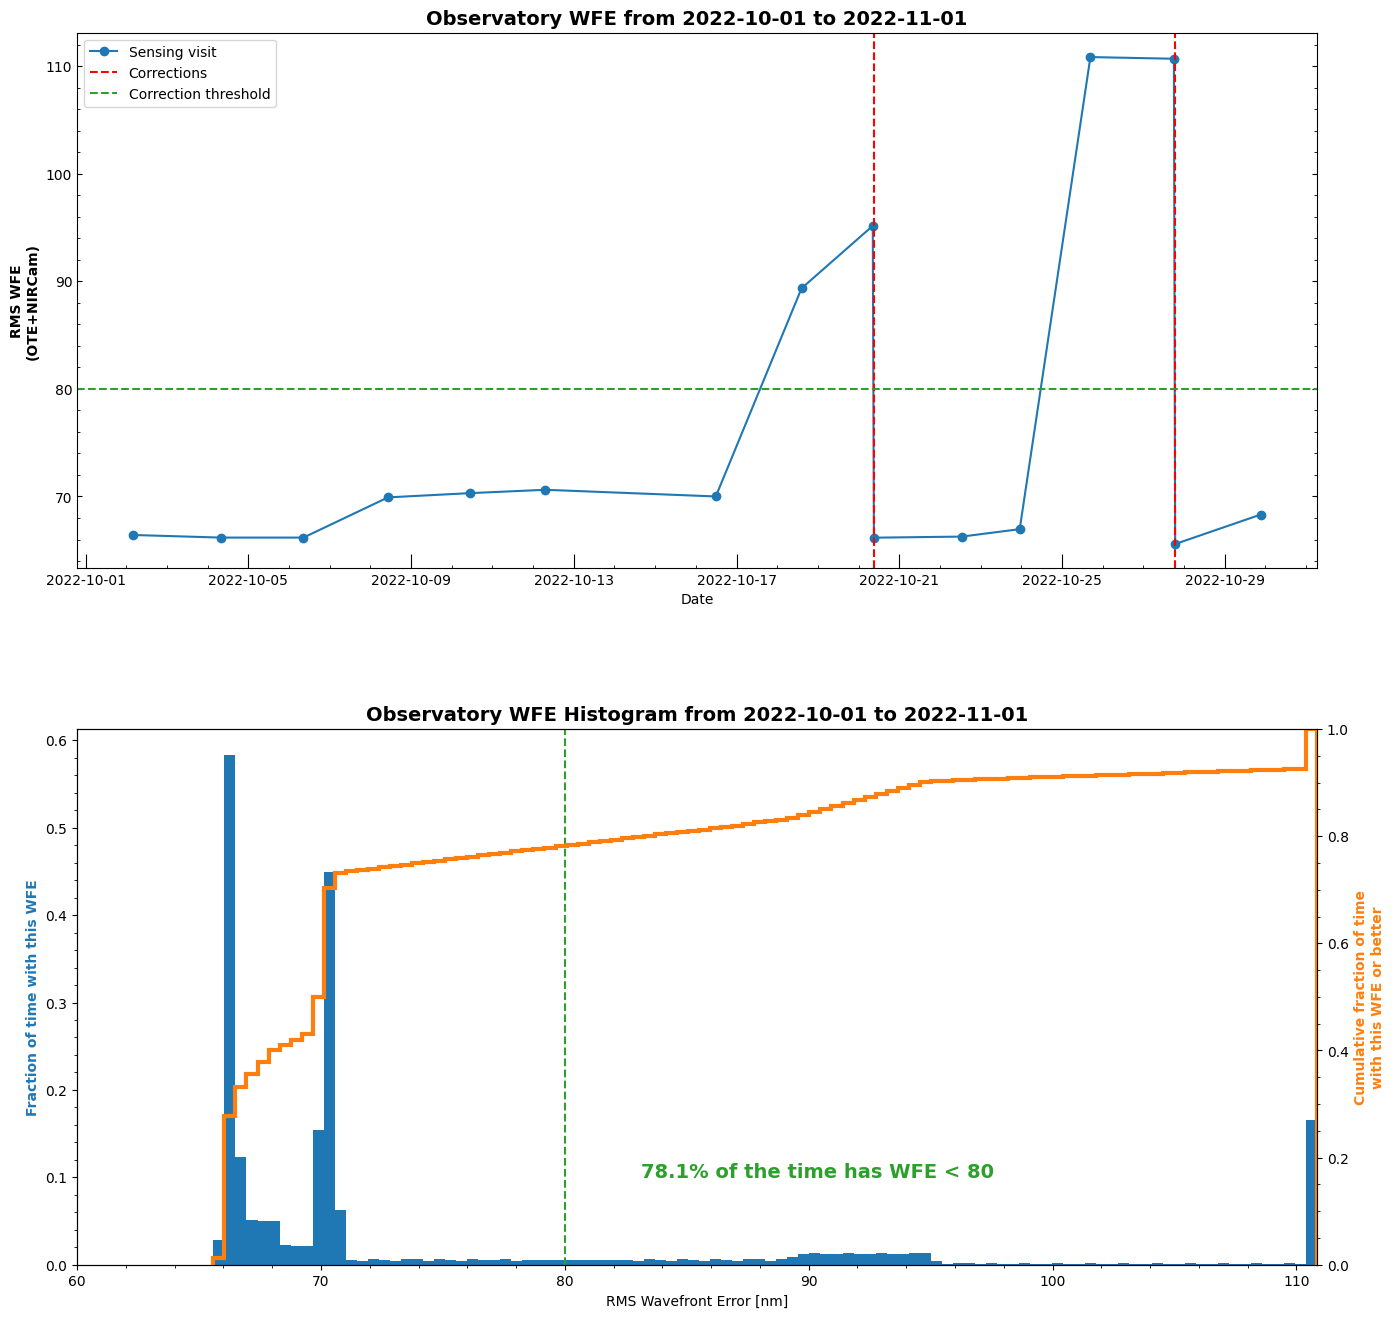

In [39]:
# or select a particular time period
start_date =  astropy.time.Time('2022-10-01')
end_date =  astropy.time.Time('2022-11-01')
webbpsf.trending.wfe_histogram_plot(opdtable, start_date = start_date, end_date = end_date, thresh=80 )

<a id='single'></a>
### Load a Single OPD
Inspect the OPD table above for an OPD around your observation

In [54]:

nrc = webbpsf.NIRCam()
nrc.filter =  'F212N'
opd_fn = 'R2022120204-NRCA3_FP1-1.fits'
nrc.load_wss_opd(opd_fn, output_path = output_path)
fov_pixels = 511
psf = nrc.calc_psf(oversample=4, fov_pixels = fov_pixels)

Importing and format-converting OPD from /ifs/jwst/tel/flight/WebbPSF-OPD/R2022120204-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point


In [55]:
psf.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     104   (2044, 2044)   float64   
  1  DET_SAMP      1 ImageHDU       106   (511, 511)   float64   
  2  OVERDIST      1 ImageHDU       150   (2044, 2044)   float64   
  3  DET_DIST      1 ImageHDU       151   (511, 511)   float64   


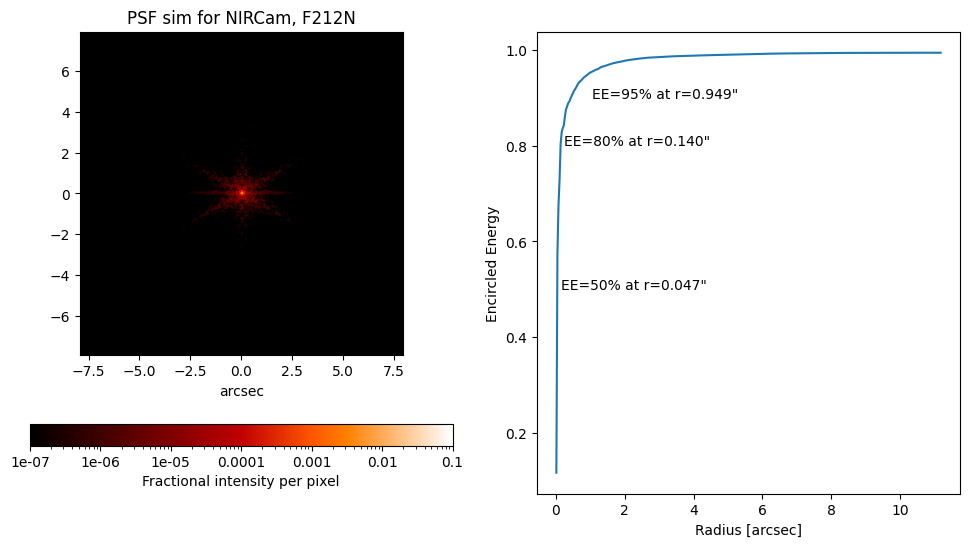

In [74]:
# display the PSF and plot the encircled energy
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
webbpsf.display_psf(psf, colorbar_orientation='horizontal')
axis2 = plt.subplot(1,2,2)
webbpsf.display_ee(psf, ext = 1,ax=axis2)

<a id='psfdiff'></a>
### PSF properties and differences 


In [71]:
pixelscale = nrc.pixelscale 
ee_pixel_radius = 2.5
ee_arcsec_radius = ee_pixel_radius * pixelscale
ee_psf = poppy.measure_ee(psf, ext = 1, normalize='total')
ee_val = ee_psf(ee_arcsec_radius)
print("ee ({}px, {:.3f}arsec)  = {:.4f}".format(ee_pixel_radius,ee_arcsec_radius,ee_val.item(0)))

ee (2.5px, 0.078arsec)  = 0.6639


In [58]:
def measure_fwhm(array):
    """Fit a Gaussian2D model to a PSF and return the fitted PSF
    the FWHM is x and y can be found with fitted_psf.x_fwhm, fitted_psf.y_fwhm

    Parameters
    ----------
    array : numpy.ndarray
        Array containing PSF

    Returns
    -------
    x_fwhm : float
        FWHM in x direction in units of pixels

    y_fwhm : float
        FWHM in y direction in units of pixels
        
    x_mean : float
        x centroid position in units of pixels
    
    y_mean : float
        y centroid position in units of pixels
    
    """
    yp, xp = array.shape
    y, x, = np.mgrid[:yp, :xp]
    p_init = models.Gaussian2D(amplitude = array.max(), x_mean=xp*0.5,y_mean=yp*0.5)
    fit_p = fitting.LevMarLSQFitter()
    fitted_psf = fit_p(p_init, x, y, array)
    return fitted_psf


In [59]:
fitted_psf = measure_fwhm(psf["DET_SAMP"].data)
print("FWHM X-direction: {:.3f}, FWHM y-direction: {:.2f}".format(fitted_psf.x_fwhm,fitted_psf.y_fwhm))

FWHM X-direction: 2.245, FWHM y-direction: 2.29


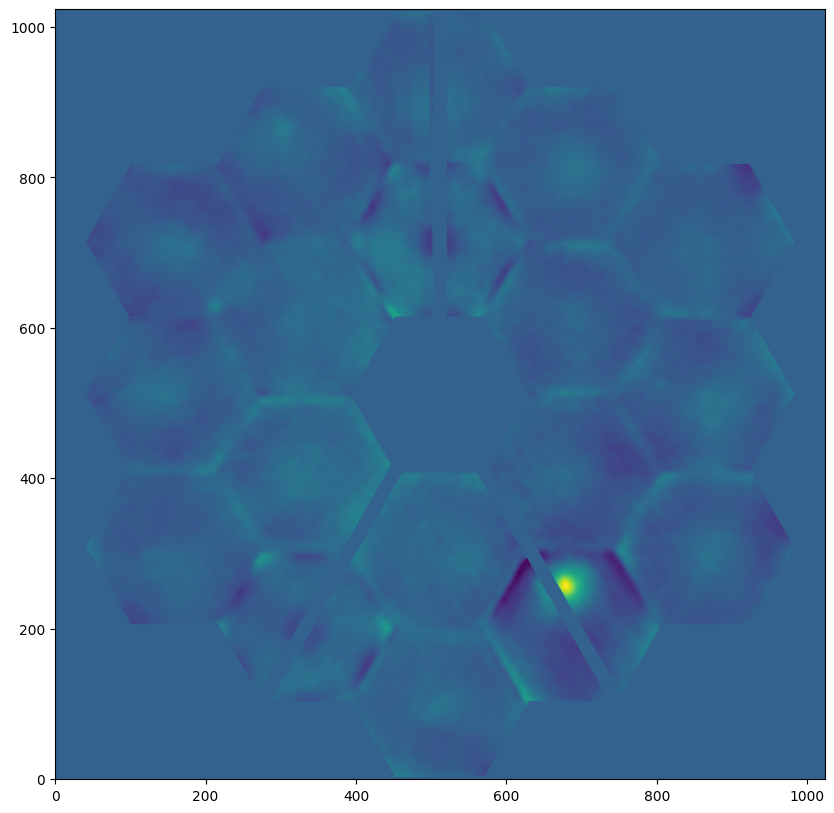

In [81]:
#Note that the OPD is loaded in WebbPSF instrument object
#norm = ImageNormalize(stretch=LinearStretch(), vmin = 1e-9 , vmax = 1e-7)
plt.figure(figsize = [10,10])
plt.imshow(nrc.pupilopd[0].data,  origin = 'lower')



In [61]:
#check OPD header information
nrc.pupilopd[0].header

SIMPLE  =                    T / Written by IDL:  Fri Dec  2 22:39:16 2022      
BITPIX  =                  -64 / Number of bits per data pixel                  
NAXIS   =                    2 / Number of data axes                            
NAXIS1  =                 1024                                                  
NAXIS2  =                 1024                                                  
EXTEND  =                    T / FITS data may contain extensions               
DATE    = '2022-12-02'         / Creation UTC (CCCC-MM-DD) date of FITS header  
COMMENT FITS (Flexible Image Transport System) format is defined in 'Astronomy  
COMMENT and Astrophysics', volume 376, page 359; bibcode 2001A&A...376..359H    
FILECONT= 'Analysis output products' /                                          
TSTAMP  = '2022-12-02T22:39:16' /                                               
DATE-OBS= '2022-12-02'         /                                                
TIME-OBS= '04:02:21.595'    

In [62]:
# Let's calculate the difference between two different times

nrc = webbpsf.NIRCam()
nrc.filter =  'F212N'
opd_fn = 'R2022120404-NRCA3_FP1-1.fits'
nrc.load_wss_opd(opd_fn, output_path = output_path)
fov_pixels = 511
psf2 = nrc.calc_psf(oversample=4, fov_pixels = fov_pixels)




Found OPD file previously downloaded: R2022120404-NRCA3_FP1-1.fits
Importing and format-converting OPD from /ifs/jwst/tel/flight/WebbPSF-OPD/R2022120404-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point


In [68]:
pixelscale = nrc.pixelscale
ee_pixel_radius = 2.5
ee_arcsec_radius = ee_pixel_radius * pixelscale
ee_psf = poppy.measure_ee(psf2, ext = 1, normalize='total')
ee_val = ee_psf(ee_arcsec_radius)
print("ee ({}px, {:.3f}arsec)  = {:.4f}".format(ee_pixel_radius,ee_arcsec_radius,ee_val.item(0)))

ee (2.5px, 0.078arsec)  = 0.6637


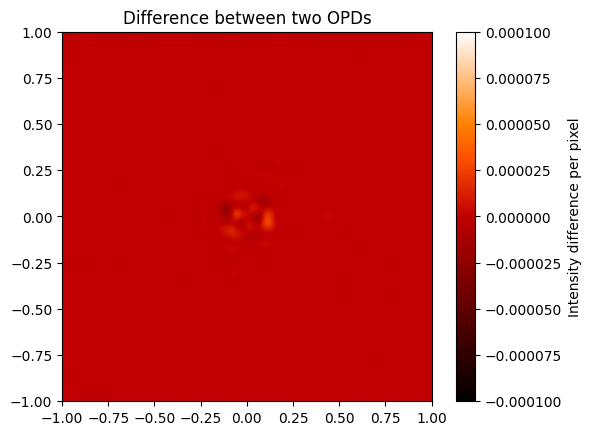

In [72]:
webbpsf.display_psf_difference(psf, psf2, imagecrop = 2 , title = 'Difference between two OPDs', cmap = 'gist_heat')